## Detecting Twitter Bots

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
import time
from sklearn import metrics
warnings.filterwarnings("ignore")
%matplotlib inline

In [23]:
filepath = 'D:/MachineLearning-Detecting-Twitter-Bots-master/FinalProjectAndCode/kaggle_data/'
file= filepath+'training_data_2_csv_UTF.csv'

training_data = pd.read_csv(file)
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

### Exploratory Data Analysis

#### Identifying Missingness in the data

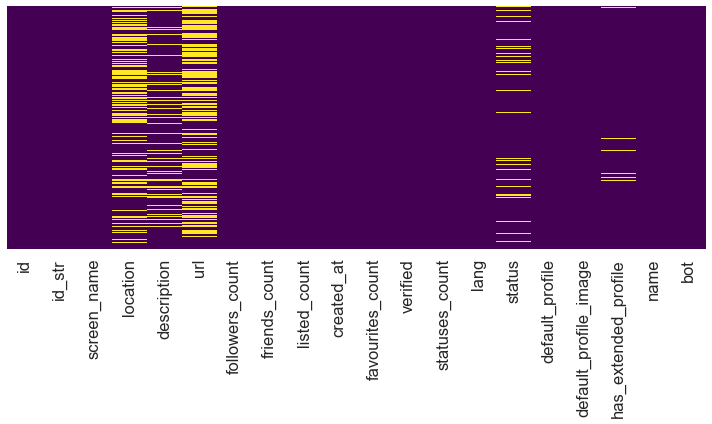

In [24]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

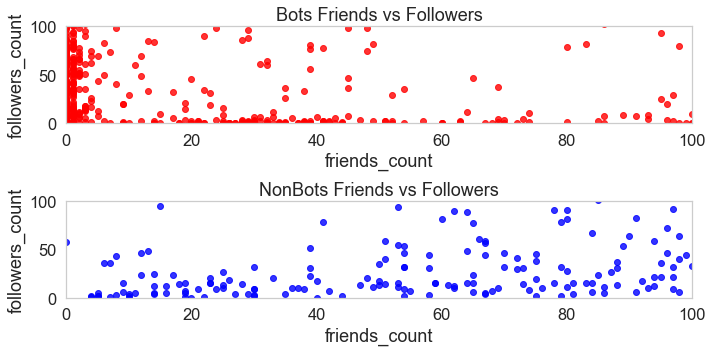

In [25]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(bots.friends_count, bots.followers_count, color='red', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(nonbots.friends_count, nonbots.followers_count, color='blue', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

#### Identifying Imbalance in the data

In [26]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


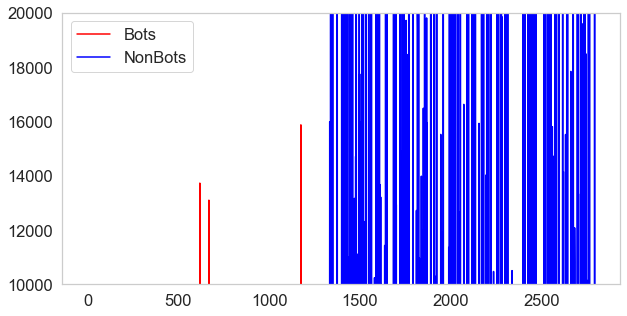

In [27]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='red', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [28]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

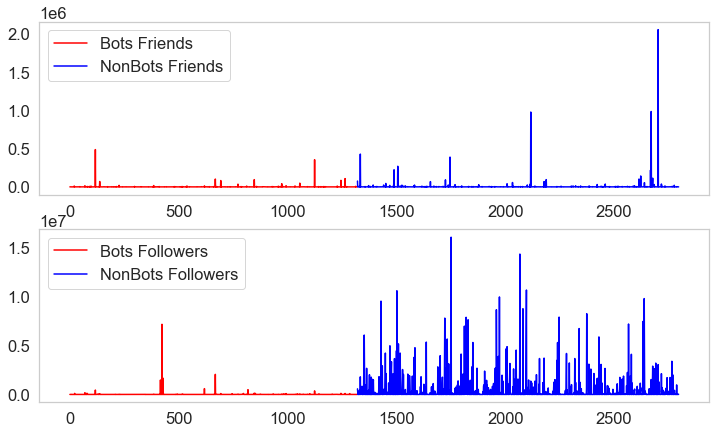

In [29]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='red', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='red', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [30]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [31]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [32]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

### Feature Independence using Spearman correlation

In [33]:
df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,0.270435,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,-0.577157,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.427638,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,-0.681034,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.104797,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,-0.419815,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,-0.533971,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,0.197929,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,0.190986,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.044056,-0.843429,-0.266342,0.606771


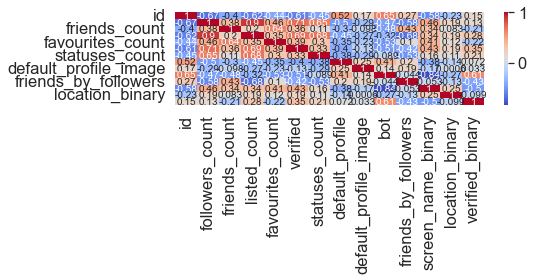

In [35]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(method='spearman'), cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

Result:
- There is no correlation between **id, statuses_count, default_profile, default_profile_image** and target variable.
- There is strong correlation between **verified, listed_count, friends_count, followers_count** and target variable.
- We cannot perform correlation for categorical attributes. So we will take **screen_name, name, description, status** into feature engineering. While use **verified, listed_count** for feature extraction.

#### Performing Feature Engineering

In [45]:

filepath = 'D:/MachineLearning-Detecting-Twitter-Bots-master/FinalProjectAndCode/kaggle_data/'
file= open(filepath+'training_data_2_csv_UTF.csv', mode='r', encoding='utf-8', errors='ignore')

training_data = pd.read_csv(file)

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

#### Performing Feature Extraction

In [46]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

## Implementing Different Models

#### Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.88707
Test Accuracy: 0.87857


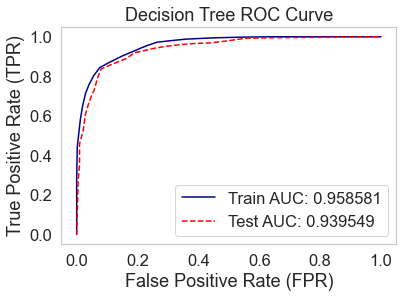

In [48]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Result: Decision Tree gives very good performance and generalizes well. But it may be overfitting as AUC is 0.937, so we will try other models.

#### Multinomial Naive Bayes Classifier

In [49]:
from sklearn.naive_bayes import MultinomialNB

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.67961
Test Accuracy: 0.69762


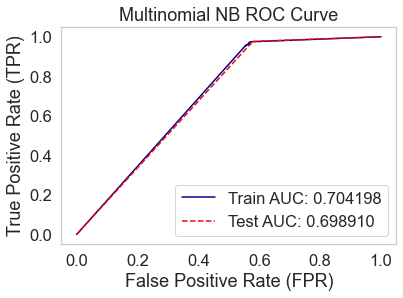

In [50]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Result: Clearly, Multinomial Niave Bayes peforms poorly and is not a good choice as the Train AUC is just 0.556 and Test is 0.555.

#### Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.87583
Test Accuracy: 0.86190


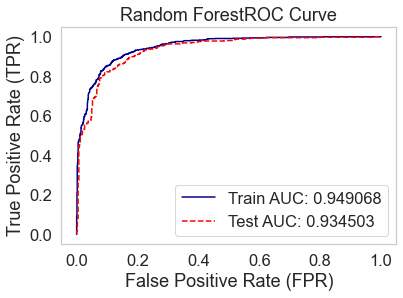

In [52]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#### Our Classifier

Training the Bot detection classifier. Please wait a few seconds.
Train Accuracy:  0.9666507860886137
Test Accuracy:  0.9738751814223512
Predicted results are saved to submission.csv. File shape: (575, 2)


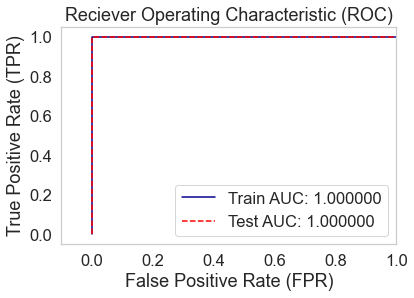

Time duration: 14.713730812072754 seconds.


In [53]:
class twitter_bot(object):
    def __init__(self):
        pass

    def perform_train_test_split(df):
        msk = np.random.rand(len(df)) < 0.75
        train, test = df[msk], df[~msk]
        X_train, y_train = train, train.iloc[:,-1]
        X_test, y_test = test, test.iloc[:, -1]
        return (X_train, y_train, X_test, y_test)

    def bot_prediction_algorithm(df):
        # creating copy of dataframe
        train_df = df.copy()
        # performing feature engineering on id and verfied columns
        # converting id to int
        train_df['id'] = train_df.id.apply(lambda x: int(x))
        #train_df['friends_count'] = train_df.friends_count.apply(lambda x: int(x))
        train_df['followers_count'] = train_df.followers_count.apply(lambda x: 0 if x=='None' else int(x))
        train_df['friends_count'] = train_df.friends_count.apply(lambda x: 0 if x=='None' else int(x))
        #We created two bag of words because more bow is stringent on test data, so on all small dataset we check less
        if train_df.shape[0]>600:
            #bag_of_words_for_bot
            bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                           r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                           r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                           r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
        else:
            # bag_of_words_for_bot
            bag_of_words_bot = r'bot|b0t|cannabis|mishear|updates every'

        # converting verified into vectors
        train_df['verified'] = train_df.verified.apply(lambda x: 1 if ((x == True) or x == 'TRUE') else 0)

        # check if the name contains bot or screenname contains b0t
        condition = ((train_df.name.str.contains(bag_of_words_bot, case=False, na=False)) |
                     (train_df.description.str.contains(bag_of_words_bot, case=False, na=False)) |
                     (train_df.screen_name.str.contains(bag_of_words_bot, case=False, na=False)) |
                     (train_df.status.str.contains(bag_of_words_bot, case=False, na=False))
                     )  # these all are bots
        predicted_df = train_df[condition]  # these all are bots
        predicted_df.bot = 1
        predicted_df = predicted_df[['id', 'bot']]

        # check if the user is verified
        verified_df = train_df[~condition]
        condition = (verified_df.verified == 1)  # these all are nonbots
        predicted_df1 = verified_df[condition][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        # check if description contains buzzfeed
        buzzfeed_df = verified_df[~condition]
        condition = (buzzfeed_df.description.str.contains("buzzfeed", case=False, na=False))  # these all are nonbots
        predicted_df1 = buzzfeed_df[buzzfeed_df.description.str.contains("buzzfeed", case=False, na=False)][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        # check if listed_count>16000
        listed_count_df = buzzfeed_df[~condition]
        listed_count_df.listed_count = listed_count_df.listed_count.apply(lambda x: 0 if x == 'None' else x)
        listed_count_df.listed_count = listed_count_df.listed_count.apply(lambda x: int(x))
        condition = (listed_count_df.listed_count > 16000)  # these all are nonbots
        predicted_df1 = listed_count_df[condition][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        #remaining
        predicted_df1 = listed_count_df[~condition][['id', 'bot']]
        predicted_df1.bot = 0 # these all are nonbots
        predicted_df = pd.concat([predicted_df, predicted_df1])
        return predicted_df

    def get_predicted_and_true_values(features, target):
        y_pred, y_true = twitter_bot.bot_prediction_algorithm(features).bot.tolist(), target.tolist()
        return (y_pred, y_true)

    def get_accuracy_score(df):
        (X_train, y_train, X_test, y_test) = twitter_bot.perform_train_test_split(df)
        # predictions on training data
        y_pred_train, y_true_train = twitter_bot.get_predicted_and_true_values(X_train, y_train)
        train_acc = metrics.accuracy_score(y_pred_train, y_true_train)
        #predictions on test data
        y_pred_test, y_true_test = twitter_bot.get_predicted_and_true_values(X_test, y_test)
        test_acc = metrics.accuracy_score(y_pred_test, y_true_test)
        return (train_acc, test_acc)

    def plot_roc_curve(df):
        (X_train, y_train, X_test, y_test) = twitter_bot.perform_train_test_split(df)
        # Train ROC
        y_pred_train, y_true = twitter_bot.get_predicted_and_true_values(X_train, y_train)
        scores = np.linspace(start=0.01, stop=0.9, num=len(y_true))
        fpr_train, tpr_train, threshold = metrics.roc_curve(y_pred_train, scores, pos_label=0)
        plt.plot(fpr_train, tpr_train, label='Train AUC: %5f' % metrics.auc(fpr_train, tpr_train), color='darkblue')
        #Test ROC
        y_pred_test, y_true = twitter_bot.get_predicted_and_true_values(X_test, y_test)
        scores = np.linspace(start=0.01, stop=0.9, num=len(y_true))
        fpr_test, tpr_test, threshold = metrics.roc_curve(y_pred_test, scores, pos_label=0)
        plt.plot(fpr_test,tpr_test, label='Test AUC: %5f' %metrics.auc(fpr_test,tpr_test), ls='--', color='red')
        #Misc
        plt.xlim([-0.1,1])
        plt.title("Reciever Operating Characteristic (ROC)")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend(loc='lower right')
        plt.show()


if __name__ == '__main__':
    start = time.time()
    print("Training the Bot detection classifier. Please wait a few seconds.")
    filepath = 'D:/MachineLearning-Detecting-Twitter-Bots-master/FinalProjectAndCode/kaggle_data/'
    train_df = pd.read_csv(filepath + 'training_data_2_csv_UTF.csv')
    test_df = pd.read_csv(filepath + 'test_data_4_students.csv', sep='\t', encoding='ISO-8859-1')
    print("Train Accuracy: ", twitter_bot.get_accuracy_score(train_df)[0])
    print("Test Accuracy: ", twitter_bot.get_accuracy_score(train_df)[1])

    #predicting test data results
    predicted_df = twitter_bot.bot_prediction_algorithm(test_df)
    # preparing subission file
    predicted_df.to_csv('submission.csv', index=False)
    print("Predicted results are saved to submission.csv. File shape: {}".format(predicted_df.shape))
    #ssss: " ,twitter_bot.get_bot_predictions(test_df))
    twitter_bot.plot_roc_curve(train_df)
    print("Time duration: {} seconds.".format(time.time()-start))
    
    

### ROC Comparison after tuning the baseline model

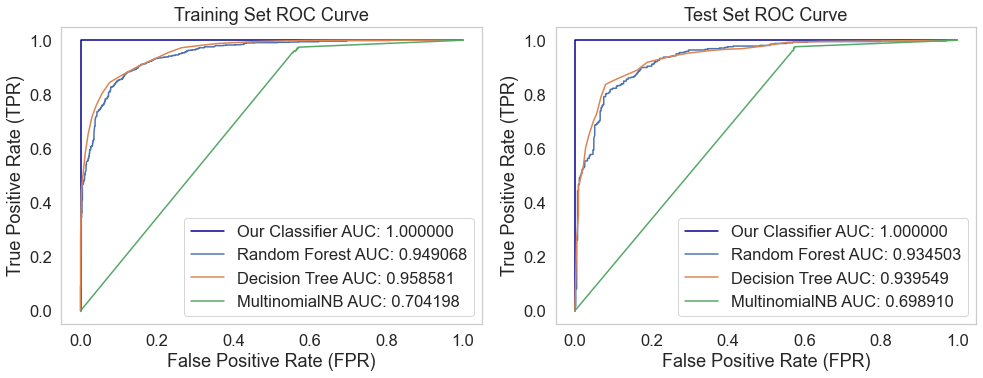

In [54]:
plt.figure(figsize=(14,10))
(X_train, y_train, X_test, y_test) = twitter_bot.perform_train_test_split(df)
#Train ROC
y_pred_train, y_true = twitter_bot.get_predicted_and_true_values(X_train, y_train)
scores = np.linspace(start=0, stop=1, num=len(y_true))
fpr_botc_train, tpr_botc_train, threshold = metrics.roc_curve(y_pred_train, scores, pos_label=0)

#Test ROC
y_pred_test, y_true = twitter_bot.get_predicted_and_true_values(X_test, y_test)
scores = np.linspace(start=0, stop=1, num=len(y_true))
fpr_botc_test, tpr_botc_test, threshold = metrics.roc_curve(y_pred_test, scores, pos_label=0)

#Train ROC
plt.subplot(2,2,1)
plt.plot(fpr_botc_train, tpr_botc_train, label='Our Classifier AUC: %5f' % metrics.auc(fpr_botc_train,tpr_botc_train), color='darkblue')
plt.plot(fpr_rf_train, tpr_rf_train, label='Random Forest AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_dt_train, tpr_dt_train, label='Decision Tree AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_mnb_train, tpr_mnb_train, label='MultinomialNB AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.title("Training Set ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#Test ROC
plt.subplot(2,2,2)
plt.plot(fpr_botc_test,tpr_botc_test, label='Our Classifier AUC: %5f' %metrics.auc(fpr_botc_test,tpr_botc_test), color='darkblue')
plt.plot(fpr_rf_test, tpr_rf_test, label='Random Forest AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.plot(fpr_dt_test, tpr_dt_test, label='Decision Tree AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.plot(fpr_mnb_test, tpr_mnb_test, label='MultinomialNB AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Test Set ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.tight_layout()

### Thank you.